+-------------------+------------+------+--------+--------+----+--------------------+----+--------------------+
|               date|primary_type|arrest|domestic|district|year|         description|iucr|location_description|
+-------------------+------------+------+--------+--------+----+--------------------+----+--------------------+
|2025-06-26 00:30:00|     ROBBERY| false|   false|       1|2025|     ARMED - HANDGUN|031A|              STREET|
|2018-06-03 16:00:00|     ROBBERY| false|   false|       1|2018|STRONGARM - NO WE...|0320|          RESTAURANT|
|2018-04-22 05:15:00|     ROBBERY| false|   false|       1|2018|STRONGARM - NO WE...|0320|              STREET|
|2019-10-14 12:43:00|     ROBBERY|  true|   false|       1|2019|STRONGARM - NO WE...|0320|              STREET|
|2018-07-17 03:40:00|     ROBBERY| false|   false|       1|2018|STRONGARM - NO WE...|0320|            SIDEWALK|
|2016-06-23 16:05:00|     ROBBERY| false|   false|       1|2016|STRONGARM - NO WE...|0320|              

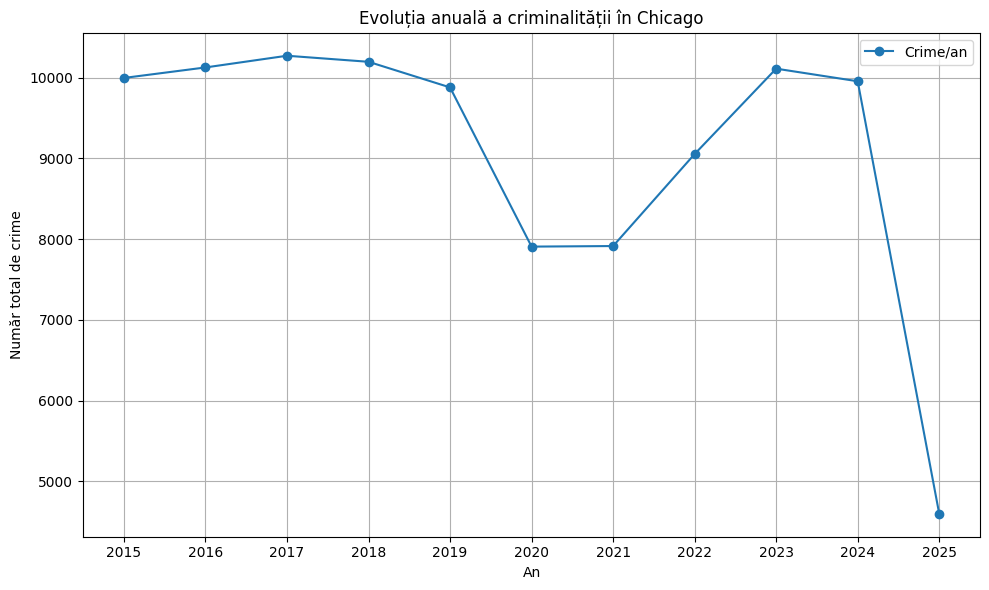

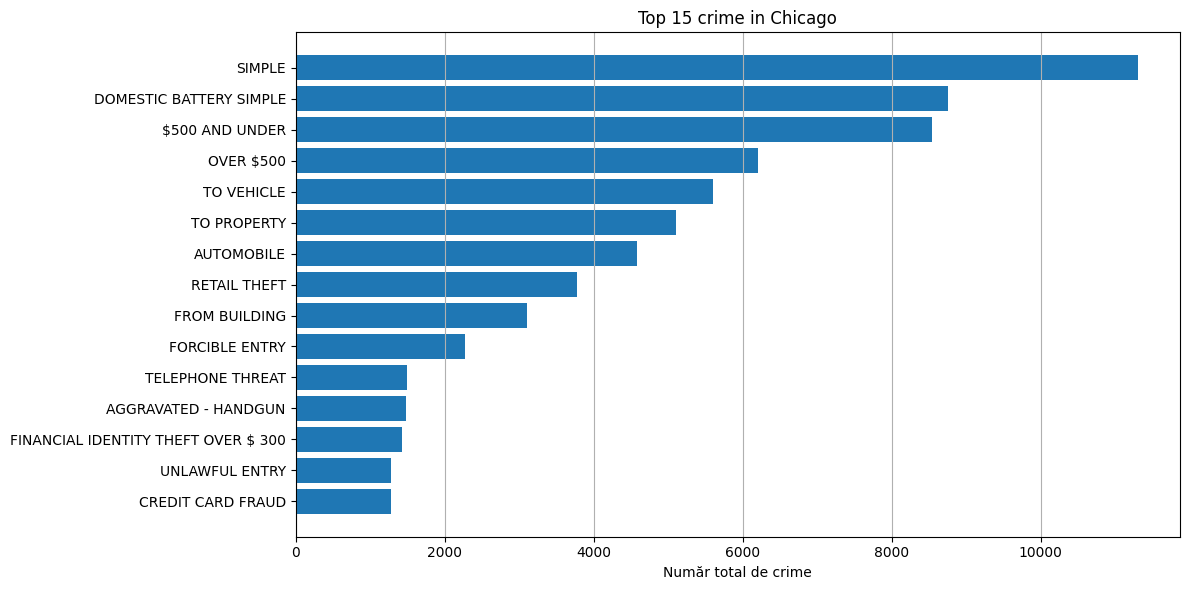

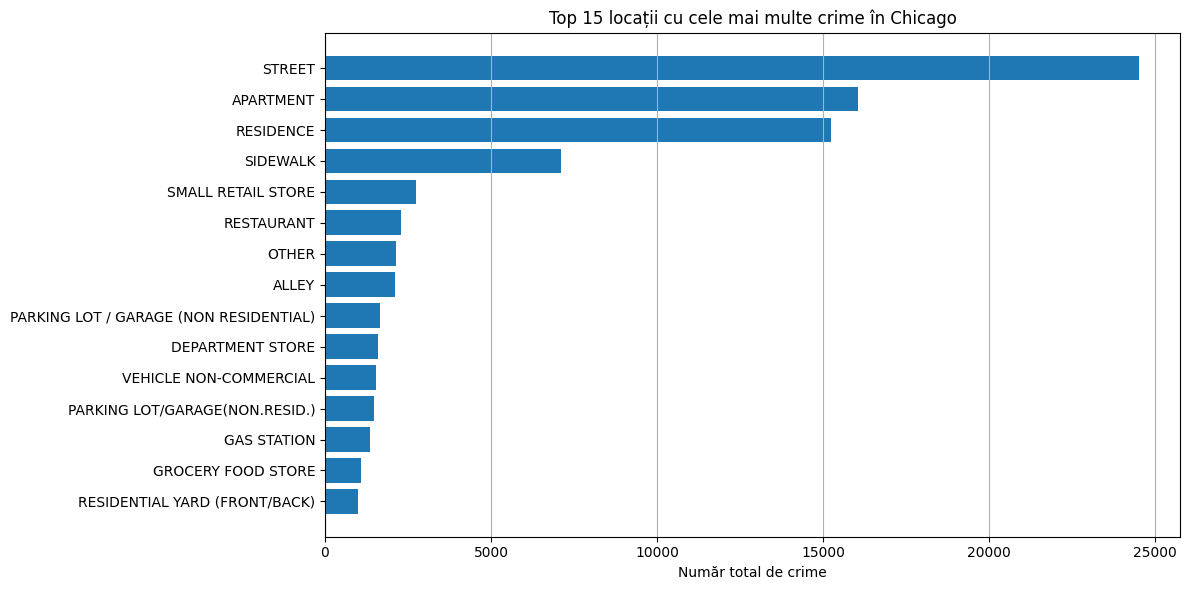

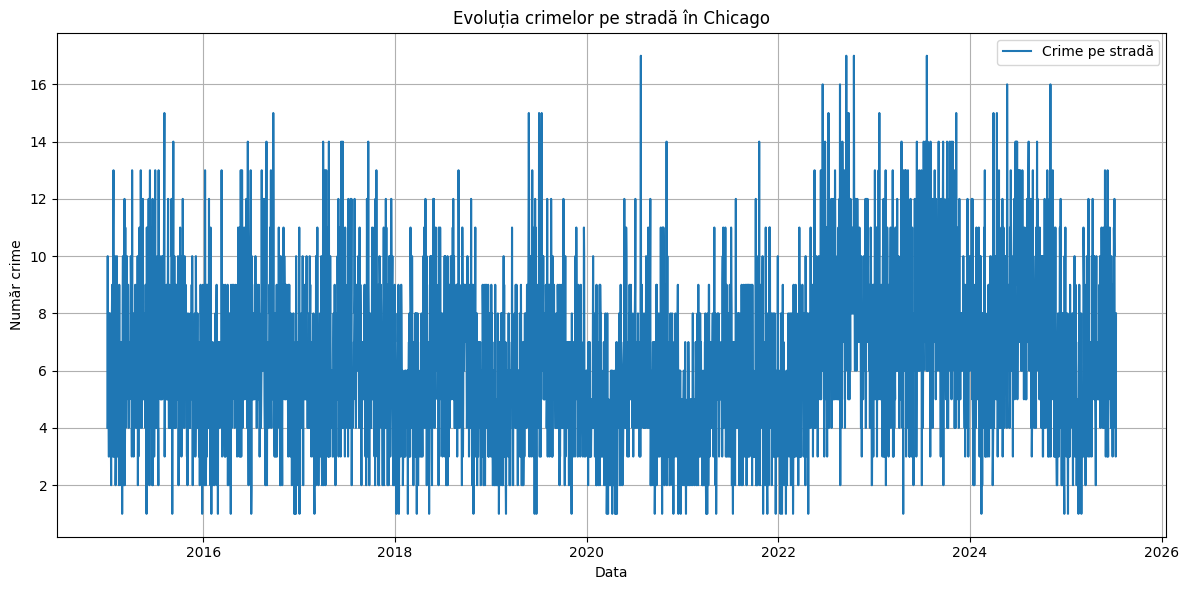

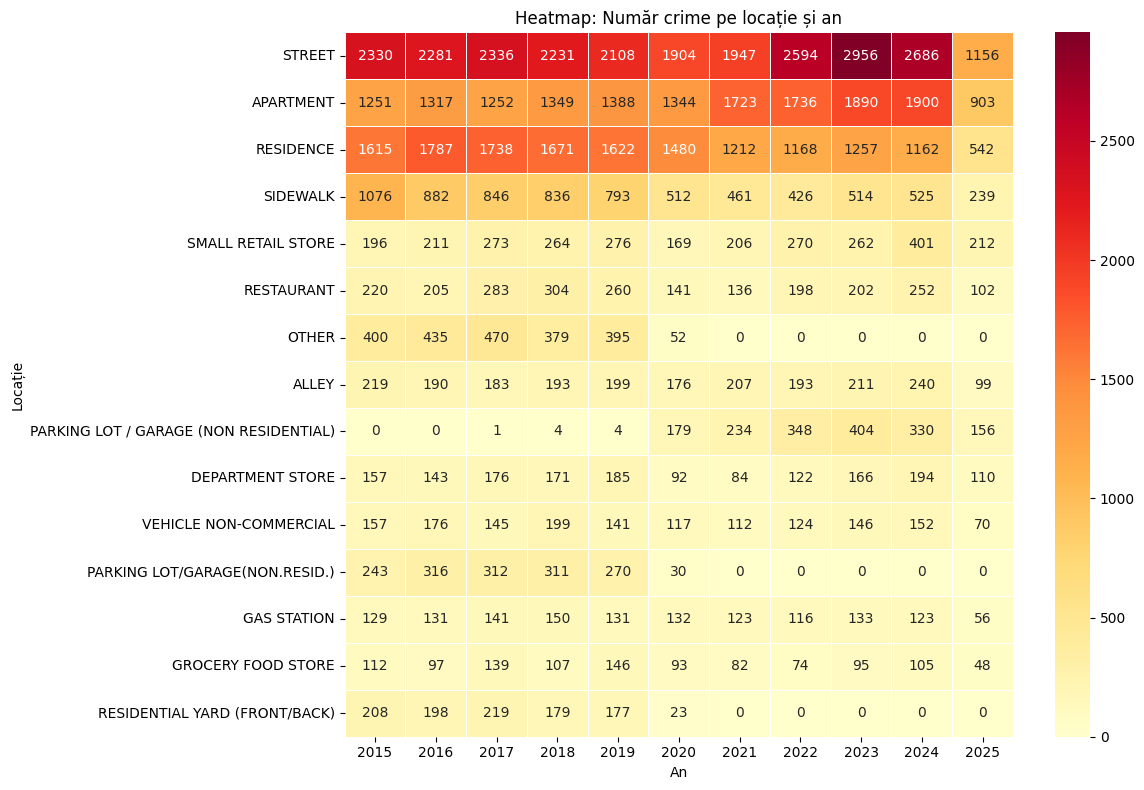

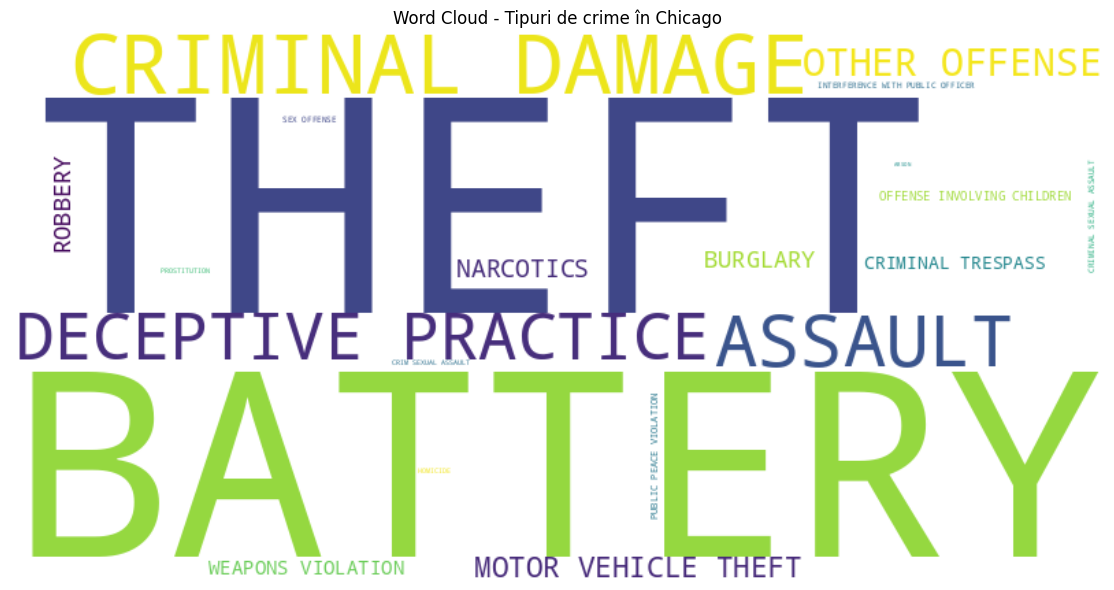

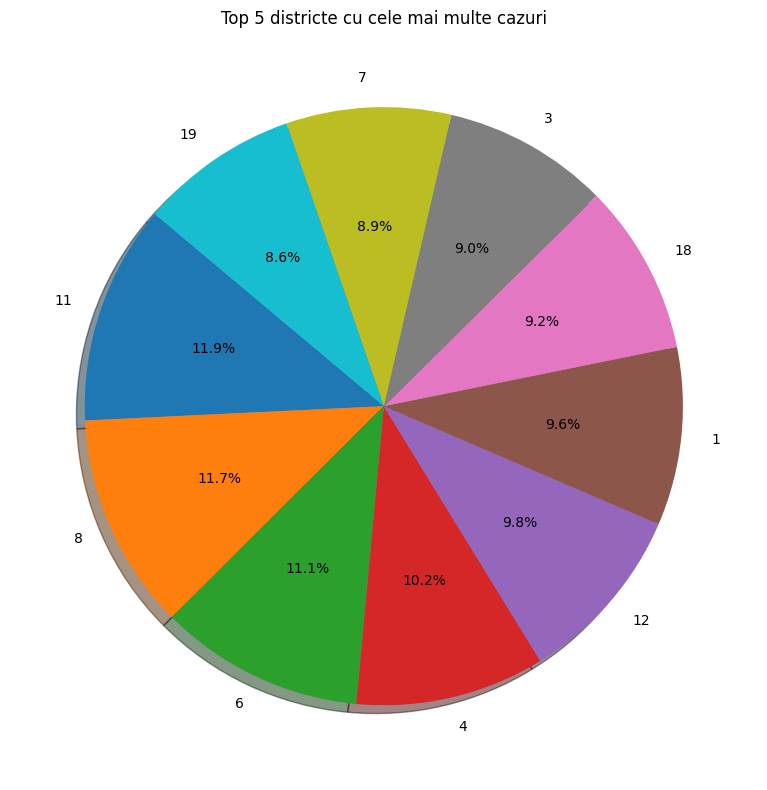

In [4]:
from google.cloud import bigquery
from pyspark.sql import SparkSession
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from pyspark.ml.feature import StringIndexer, VectorAssembler

from pyspark.sql.functions import log1p
from pyspark.sql.functions import col, unix_timestamp
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.classification import MultilayerPerceptronClassifier


client = bigquery.Client()
spark = SparkSession.builder.appName("Chicago Crimes").getOrCreate()

query = """
SELECT date, primary_type, arrest, domestic, district, year, description, iucr, location_description
FROM `bigquery-public-data.chicago_crime.crime`
WHERE year BETWEEN 2015 AND 2025
and date is not null
and primary_type is not null
and arrest is not null
and domestic is not null
and district is not null
and year is not null
and description is not null
and iucr is not null
and location_description is not null
limit 100000;
"""

df = client.query(query).to_dataframe()
spark_df = spark.createDataFrame(df)
spark_df.show(10)

pandas_df = spark_df.toPandas()

#1 Evoluția zilnică a criminalității în Chicago
pandas_df["date"] = pd.to_datetime(pandas_df["date"])
pandas_df["date_only"] = pandas_df["date"].dt.date

crime_counts_per_year = pandas_df.groupby("year").size().reset_index(name="crime_count")
plt.figure(figsize=(10, 6))
plt.plot(crime_counts_per_year["year"], crime_counts_per_year["crime_count"], marker='o', label="Crime/an")
plt.xlabel("An")
plt.ylabel("Număr total de crime")
plt.title("Evoluția anuală a criminalității în Chicago")
plt.xticks(crime_counts_per_year["year"])  # afisează fiecare an pe axa X
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#2 Top 15 crime in Chicago
description_crime_counts = pandas_df.dropna(subset=["description"])
description_crime_counts = (
    description_crime_counts.groupby("description")
    .size()
    .reset_index(name="crime_count")
    .sort_values("crime_count", ascending=False)
)
top_descriptions = description_crime_counts.head(15)
plt.figure(figsize=(12, 6))
plt.barh(top_descriptions["description"], top_descriptions["crime_count"])
plt.xlabel("Număr total de crime")
plt.title("Top 15 crime in Chicago")
plt.gca().invert_yaxis()  # cele mai frecvente sus
plt.grid(axis="x")
plt.tight_layout()
plt.show()

#3 Top 15 locații cu cele mai multe crime în Chicag
location_crime_counts = pandas_df.dropna(subset=["location_description"])
location_crime_counts = (
    location_crime_counts.groupby("location_description")
    .size()
    .reset_index(name="crime_count")
    .sort_values("crime_count", ascending=False)
)
top_locations = location_crime_counts.head(15)
plt.figure(figsize=(12, 6))
plt.barh(top_locations["location_description"], top_locations["crime_count"])
plt.xlabel("Număr total de crime")
plt.title("Top 15 locații cu cele mai multe crime în Chicago")
plt.gca().invert_yaxis()  # cele mai frecvente sus
plt.grid(axis="x")
plt.tight_layout()
plt.show()

#4 Evoluția crimelor pe stradă în Chicago
pandas_df["date"] = pd.to_datetime(pandas_df["date"])
pandas_df["date_only"] = pandas_df["date"].dt.date
street_crimes = pandas_df[pandas_df["location_description"] == "STREET"]
street_crimes_per_day = (
    street_crimes.groupby("date_only")
    .size()
    .reset_index(name="crime_count")
    .sort_values("date_only")
)
plt.figure(figsize=(12, 6))
plt.plot(street_crimes_per_day["date_only"], street_crimes_per_day["crime_count"], label="Crime pe stradă")
plt.xlabel("Data")
plt.ylabel("Număr crime")
plt.title("Evoluția crimelor pe stradă în Chicago")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#5 Heatmap cu cele mai frecvente 15 locații
heatmap_data = pandas_df.dropna(subset=["location_description", "year"])
pivot_table = heatmap_data.pivot_table(
    index="location_description",
    columns="year",
    aggfunc="size",
    fill_value=0
)
top_locations = pivot_table.sum(axis=1).sort_values(ascending=False).head(15).index
filtered_pivot = pivot_table.loc[top_locations]
plt.figure(figsize=(12, 8))
sns.heatmap(filtered_pivot, cmap="YlOrRd", linewidths=0.5, annot=True, fmt="d")
plt.title("Heatmap: Număr crime pe locație și an")
plt.xlabel("An")
plt.ylabel("Locație")
plt.tight_layout()
plt.show()

#6 Wordcloud pnetru a evidentia densitatea crimelor pentru fiecare tip
type_counts = pandas_df["primary_type"].value_counts().to_dict()
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(type_counts)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud - Tipuri de crime în Chicago")
plt.tight_layout()
plt.show()

#6 PIE
# Top 5 districte cu cele mai multe cazuri
district_counts = (
    pandas_df.groupby("district")
    .size()
    .reset_index(name="crime_count")
    .sort_values("crime_count", ascending=False)
)

# Luăm doar primele 5
top5_districts = district_counts.head(10)

# Facem un pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    top5_districts["crime_count"],
    labels=top5_districts["district"],
    autopct="%1.1f%%",
    startangle=140,
    shadow=True
)
plt.title("Top 5 districte cu cele mai multe cazuri")
plt.tight_layout()
plt.show()


Accuracy: 0.571313253619898
RMSE: 0.57
+----------+--------+
|prediction|district|
+----------+--------+
|       6.0|       6|
|       8.0|       8|
|       4.0|       4|
|       4.0|       4|
|       3.0|       3|
|      11.0|       9|
|       3.0|       3|
|       7.0|       7|
|       6.0|       6|
|       6.0|       6|
+----------+--------+
only showing top 10 rows

Random Forest Accuracy: 0.9171
Random Forest F1-score: 0.9089
+----------+--------+--------------------+
|prediction|district|            features|
+----------+--------+--------------------+
|       6.0|       6|[1.4200704E9,1.0,...|
|       8.0|       8|[1.4200812E9,0.0,...|
|       4.0|       4|[1.4200956E9,0.0,...|
|       4.0|       4|[1.4202864E9,0.0,...|
|       3.0|       3|[1.4203434E9,1.0,...|
|       9.0|       9|[1.4204484E9,0.0,...|
|       3.0|       3|[1.4205312E9,0.0,...|
|       7.0|       7|[1.4206536E9,0.0,...|
|       6.0|       6|[1.42091574E9,0.0...|
|       6.0|       6|[1.4209245E9,0.0,...|
+-----

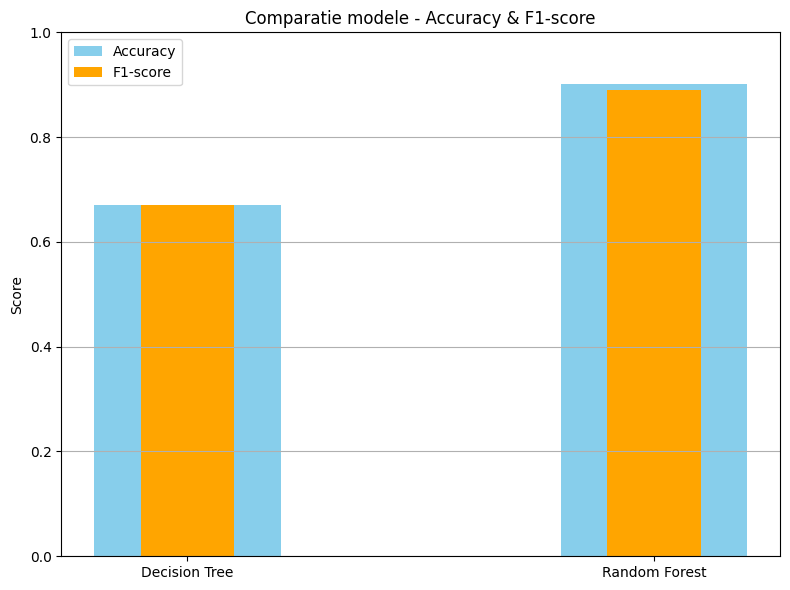

In [2]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# === DecisionTreeClassifier===

# 1. Conversie boolean -> int
spark_df = spark_df.withColumn("arrest_int", col("arrest").cast("integer"))
spark_df = spark_df.withColumn("domestic_int", col("domestic").cast("integer"))

# 2. Conversie date -> numeric (epoch time)
spark_df = spark_df.withColumn("date_numeric", unix_timestamp("date"))
indexer_label = StringIndexer(inputCol="primary_type", outputCol="label")
indexer_location = StringIndexer(inputCol="location_description", outputCol="location_idx")

# 3. Convertim string to number
indexer_label = StringIndexer(inputCol="primary_type", outputCol="label")
indexer_location = StringIndexer(inputCol="location_description", outputCol="location_idx")

indexed_df = indexer_label.fit(spark_df).transform(spark_df)
indexed_df = indexer_location.fit(indexed_df).transform(indexed_df)

# 4. Alegem doar coloane numerice
assembler = VectorAssembler(
    inputCols=[
        "date_numeric",
        "domestic_int",
        "district",
        "year",
        "location_idx",
        "arrest_int"
    ],
    outputCol="features"
)

assembled_df = assembler.transform(indexed_df).select("features", "district")

# 5. Split train/test
train_data, test_data = assembled_df.randomSplit([0.8, 0.2], seed=42)

# 6. Alegem CLASIFICATOR, nu regressor
dt = DecisionTreeClassifier(featuresCol="features", labelCol="district", maxBins=200)
dt_model = dt.fit(train_data)

# 7. Predicții
predictions = dt_model.transform(test_data)

# 8. Evaluare (accuracy)
evaluator = MulticlassClassificationEvaluator(
    labelCol="district",
    predictionCol="prediction",
    metricName="accuracy"
)
accuracy = evaluator.evaluate(predictions)
print("Accuracy:", accuracy)
rmse = evaluator.evaluate(predictions)
print(f"RMSE: {rmse:.2f}")

# Afișăm 10 predicții

predictions = dt_model.transform(test_data)
predictions.select("prediction", "district").show(10)


# === MODEL RANDOM FOREST ===

# 1. Definim RandomForestClassifier
rf = RandomForestClassifier(
    featuresCol="features",
    labelCol="district",
    numTrees=50,      # poți crește numărul arborilor pentru mai multă acuratețe
    maxDepth=10,      # adâncime maximă a fiecărui arbore
    maxBins=200,      # număr maxim de bins (important pentru variabile categorice)
    seed=42
)

# 2. Antrenăm modelul pe train_data
rf_model = rf.fit(train_data)

# 3. Facem predicții pe test_data
rf_predictions = rf_model.transform(test_data)

# 4. Evaluăm acuratețea
rf_evaluator = MulticlassClassificationEvaluator(
    labelCol="district",
    predictionCol="prediction",
    metricName="accuracy"
)

rf_accuracy = rf_evaluator.evaluate(rf_predictions)
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")

# Dacă vrei și F1-score sau weighted precision:
rf_f1 = MulticlassClassificationEvaluator(
    labelCol="district",
    predictionCol="prediction",
    metricName="f1"
).evaluate(rf_predictions)
print(f"Random Forest F1-score: {rf_f1:.4f}")

# 5. Afișăm câteva predicții
rf_predictions.select("prediction", "district", "features").show(10)

# 6. (Optional) Feature importance
print("=== Feature Importances (Random Forest) ===")
print(rf_model.featureImportances)

import matplotlib.pyplot as plt

# Valorile tale
models = ["Decision Tree", "Random Forest"]
accuracy_values = [0.6696, 0.9021]
f1_values = [0.67, 0.8894]

x = range(len(models))
plt.figure(figsize=(8,6))

# Accuracy
plt.bar(x, accuracy_values, width=0.4, label="Accuracy", color='skyblue')

# F1-score în spatele lor cu o bară mai închisă
plt.bar(x, f1_values, width=0.2, label="F1-score", color='orange')

plt.xticks(x, models)
plt.ylabel("Score")
plt.ylim(0,1)
plt.title("Comparatie modele - Accuracy & F1-score")
plt.legend()
plt.grid(axis="y")
plt.tight_layout()
plt.show()



In [10]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

indexer_district = StringIndexer(inputCol="district", outputCol="district_idx")
indexed_df = indexer_district.fit(assembled_df).transform(assembled_df)

final_df = indexed_df.select("features", "district_idx")
train_data, test_data = final_df.randomSplit([0.8, 0.2], seed=42)
input_size = train_data.first()["features"].size

# Numărul de clase = districte unice
num_classes = final_df.select("district_idx").distinct().count()

layers = [input_size, 32, 16, num_classes]

print(f"MLP Layers: {layers}")

# Logistic Regression ca model de clasificare
log_reg = LogisticRegression(
    featuresCol="features",
    labelCol="district_idx",
    maxIter=50,
    regParam=0.1,
    elasticNetParam=0.8
)

log_reg_model = log_reg.fit(train_data)
log_preds = log_reg_model.transform(test_data)

log_acc = MulticlassClassificationEvaluator(
    labelCol="district_idx",
    predictionCol="prediction",
    metricName="accuracy"
).evaluate(log_preds)
log_f1 = MulticlassClassificationEvaluator(
    labelCol="district_idx",
    predictionCol="prediction",
    metricName="f1"
).evaluate(log_preds)

print(f"Logistic Regression Accuracy: {log_acc:.4f}")
print(f"Logistic Regression F1-score: {log_f1:.4f}")





# --- Definim MLP Classifier ---
mlp = MultilayerPerceptronClassifier(
    featuresCol="features",
    labelCol="district_idx",
    layers=layers,
    maxIter=100,
    blockSize=128,
    seed=42
)

mlp_model = mlp.fit(train_data)
mlp_preds = mlp_model.transform(test_data)


mlp_acc = MulticlassClassificationEvaluator(
    labelCol="district_idx",
    predictionCol="prediction",
    metricName="accuracy"
).evaluate(mlp_preds)

mlp_f1 = MulticlassClassificationEvaluator(
    labelCol="district_idx",
    predictionCol="prediction",
    metricName="f1"
).evaluate(mlp_preds)

print(f"MLP Classifier Accuracy: {mlp_acc:.4f}")
print(f"MLP Classifier F1-score: {mlp_f1:.4f}")

# --- 9. Afișăm câteva predicții ---
mlp_preds.select("prediction", "district_idx", "features").show(10)



MLP Layers: [6, 32, 16, 23]
Logistic Regression Accuracy: 0.0697
Logistic Regression F1-score: 0.0091
MLP Classifier Accuracy: 0.0697
MLP Classifier F1-score: 0.0091
+----------+------------+--------------------+
|prediction|district_idx|            features|
+----------+------------+--------------------+
|       0.0|         2.0|[1.4200704E9,1.0,...|
|       0.0|         1.0|[1.4200812E9,0.0,...|
|       0.0|         3.0|[1.4200956E9,0.0,...|
|       0.0|         3.0|[1.4202864E9,0.0,...|
|       0.0|         7.0|[1.4203434E9,1.0,...|
|       0.0|        12.0|[1.4204484E9,0.0,...|
|       0.0|         7.0|[1.4205312E9,0.0,...|
|       0.0|         8.0|[1.4206536E9,0.0,...|
|       0.0|         2.0|[1.42091574E9,0.0...|
|       0.0|         2.0|[1.4209245E9,0.0,...|
+----------+------------+--------------------+
only showing top 10 rows

